In [1]:
import numpy as np
import torch
from torch import nn
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, f1_score, classification_report, ConfusionMatrixDisplay

In [2]:
train_audio_files_path = 'LA/LA/ASVspoof2019_LA_train/flac/'
train_labels_path = 'LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt.txt'
len(os.listdir(train_audio_files_path))

4

In [3]:
def readtxtfile(path):
    with open(path, 'r') as file:
        text = file.read().splitlines()
        return text
    
def getlabels(path):
    text = readtxtfile(path)
    filename2label = {}
    for item in tqdm(text):
        key = item.split(' ')[1]
        value = item.split(' ')[-1]
        filename2label[key] = value
        
    return filename2label

In [4]:
filename2label = getlabels(train_labels_path)

  0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
val_audio_files_path = 'LA/LA/ASVspoof2019_LA_dev/flac/'
val_labels_path = 'LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt.txt'
val_filename2label = getlabels(val_labels_path)

  0%|          | 0/4 [00:00<?, ?it/s]

3 1


(array([3., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

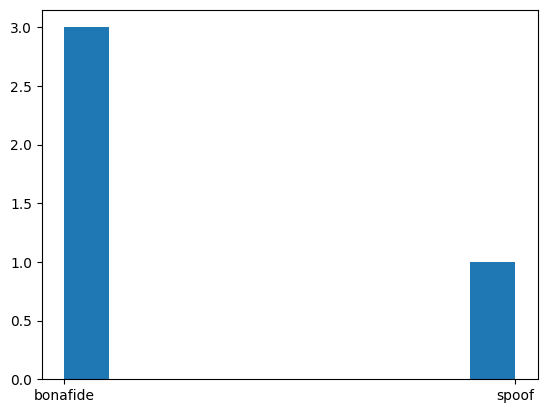

In [6]:
l = list(filename2label.values())
print(l.count('bonafide'), l.count('spoof'))
plt.hist(l)

In [7]:
test_audio_files_path = 'LA/LA/ASVspoof2019_LA_eval/flac/'
test_labels_path = 'LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt.txt'
test_filename2label = getlabels(test_labels_path)

  0%|          | 0/6 [00:00<?, ?it/s]

In [8]:
class ASVSpoof(torch.utils.data.Dataset):
    def __init__(self, audio_dir_path, num_samples, filename2label, transforms):
        super().__init__()
        self.audio_dir_path = audio_dir_path
        self.num_samples = num_samples
        self.audio_file_names = self.get_audio_file_names(filename2label)
        self.labels, self.label2id, self.id2label = self.get_labels(filename2label)
        self.transforms = transforms
        
    def __getitem__(self, index):
        signal, sr = torchaudio.load(os.path.join(self.audio_dir_path, self.audio_file_names[index]))
#         print(signal.shape)
        signal = self.mix_down_if_necessary(signal)
        signal = self.cut_if_necessary(signal)
#         print(signal.shape)
        signal = self.right_pad_if_necessary(signal)
#         print(signal.shape)
#         signal = self.transforms(signal)
#         print(signal.shape)
        label = (self.labels[index])
        return signal, label
    
    def __len__(self):
        return len(self.labels)
    
    def get_audio_file_names(self, filename2label):
        audio_file_names = list(filename2label.keys())
        audio_file_names = [name + '.flac' for name in audio_file_names] # adding extension
        return audio_file_names
    
    def get_labels(self, filename2label):
        labels = list(filename2label.values())
        id2label = {idx : label for idx, label in  enumerate(list(set(labels)))}
        label2id = {label : idx for idx, label in  enumerate(list(set(labels)))}
        labels = [label2id[label] for label in labels]
        return labels, label2id, id2label
    
    def mix_down_if_necessary(self, signal): #converting from stereo to mono
        if signal.shape[0] > 1: 
            signal = torch.mean(signal, dim = 0, keepdims = True)
        return signal
    
    def cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :num_samples]
        return signal
    
    def right_pad_if_necessary(self, signal):
        length = signal.shape[1]
        if self.num_samples > length:
            pad_last_dim = (0, num_samples - length)
            signal = torch.nn.functional.pad(signal, pad_last_dim)
        return signal

In [9]:
num_samples = 4 * 16000 # IMPORTANT!!
train_dataset = ASVSpoof(train_audio_files_path, num_samples, filename2label, None)
val_dataset = ASVSpoof(val_audio_files_path, num_samples, val_filename2label, None)
test_dataset = ASVSpoof(test_audio_files_path, num_samples, test_filename2label, None)

In [10]:
import torchaudio
import timm

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle = True, batch_size = 8)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle = True, batch_size = 8)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle = True, batch_size = 8)
t_steps = len(train_loader)
v_steps = len(val_loader)
ts_steps = len(test_loader)

In [12]:
torch.autograd.set_detect_anomaly(True)

In [13]:
from transformers import Wav2Vec2Config, Wav2Vec2Processor, Wav2Vec2Model, Wav2Vec2FeatureExtractor
import torch
import torch.nn as nn

class CustomWav2Vec2ForClassification(nn.Module):
    def __init__(self, checkpoint):
        super(CustomWav2Vec2ForClassification, self).__init__()
        config = Wav2Vec2Config.from_pretrained(checkpoint)
        self.feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(checkpoint)
        print(self.feature_extractor)
        self.wav2vec2 = Wav2Vec2Model.from_pretrained(checkpoint, config=config)
        self.blstm = nn.LSTM(config.hidden_size, config.hidden_size // 2, bidirectional = True, num_layers = 2, batch_first = True)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.pool = nn.AdaptiveAvgPool1d(128)
        self.linear = nn.Linear(199 * 128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):

        input_features = self.feature_extractor(input_ids, return_tensors="pt", sampling_rate = 16000)
        
        ff = input_features.input_values
        ff = ff.squeeze(0).to(device)

        attention_mask = attention_mask.to(device)
        # Extract features from input audio
        features = self.wav2vec2(ff, attention_mask=attention_mask, output_hidden_states = True).last_hidden_state
        
        # Pooling the last hidden states
#         pooled_output = torch.mean(features, dim=1)  # Average pooling
#         print(features.shape) # (batch_size, 199, 1024)
        # Classification
        res = features
        x,(h, c) = self.blstm(features) # (batch_size, 199, 1024)
#         print(x.shape)
        x = x + res # (batch_size, 199, 1024)
#         x = self.relu1(x)
#         x = self.dropout1(x)
        x = self.pool(x) #(batch_size, 199, 128)
        x = x.view(x.shape[0], -1) #(batch_size, 199 * 128)
#         print(x.shape)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [14]:
checkpoint = 'facebook/wav2vec2-base-960h'
model = CustomWav2Vec2ForClassification(checkpoint)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
criterion = nn.CrossEntropyLoss()

Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}



Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
import gc
x = 100
while(x != 0):
    x = gc.collect()
    torch.cuda.empty_cache()
x

0

In [16]:
def EER(labels, outputs):
    fpr, tpr, threshold = roc_curve(labels, outputs, pos_label=1)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
    eer_threshold
    eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    return eer

In [17]:
# Training loop
num_epochs = 10
train_losses = []
val_losses = []
torch.cuda.empty_cache()
for epoch in range(num_epochs):
    y_true = []
    y_pred = []
    train_loss = 0.0
    loop = tqdm(enumerate(train_loader), total = len(train_loader))
    for batch_idx, (input_ids, labels) in loop:
        loop.set_description(f'Epoch {epoch + 1} / {num_epochs} ')
#         forward pass
        model.train()
        torch.cuda.empty_cache()
        input_ids = input_ids.to(device)
        input_ids = input_ids.squeeze(1)
        labels = labels.to(device)
        labels = labels.to(device).reshape(-1, 1)
        labels = labels.type(torch.FloatTensor)
        attention_mask = torch.ones(input_ids.shape, dtype=torch.long).to(device)
        
        optimizer.zero_grad()
        
        outputs = model(input_ids, attention_mask)
        y_true.append(labels.detach().cpu().numpy())
        y_pred.append(outputs.detach().cpu().numpy())
        
        loss = criterion(outputs, labels)
        train_loss += loss.item()
#         backward pass
        loss.backward()
        optimizer.step()
        
        loop.set_postfix(Training_loss = loss.item())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    train_eer = EER(y_true, y_pred)
        
#   validation every epoch
    y_true = []
    y_pred = []
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_loop = tqdm(enumerate(val_loader), total = len(val_loader))
        for val_batch_idx, (val_input_ids, val_labels) in val_loop:
            torch.cuda.empty_cache()
            val_input_ids = val_input_ids.to(device)
            val_input_ids = val_input_ids.squeeze(1)
            val_labels = val_labels.to(device)
            val_labels = val_labels.to(device).reshape(-1, 1)
            val_labels = val_labels.type(torch.FloatTensor) #use torch.FloatTensor if on cpu
            attention_mask = torch.ones(val_input_ids.shape, dtype=torch.long).to(device)
        
        
            val_outputs = model(val_input_ids, attention_mask)
            y_true.append(val_labels.detach().cpu().numpy())
            y_pred.append(val_outputs.detach().cpu().numpy())
            curr_val_loss = criterion(val_outputs, val_labels)
            val_loss += curr_val_loss.item()
            val_loop.set_postfix(validation_loss = curr_val_loss.item())
            
    train_loss_after_epoch = train_loss / t_steps
    val_loss_after_epoch = val_loss / v_steps
    train_losses.append(train_loss_after_epoch)
    val_losses.append(val_loss_after_epoch)
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    val_eer = EER(y_true, y_pred)
    print(f'Epoch : {epoch + 1} Training loss : {train_loss_after_epoch} Train EER : {train_eer} Validation loss : {val_loss_after_epoch}  Val EER : {val_eer}')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 1 Training loss : 0.0 Train EER : 1.0 Validation loss : 0.0  Val EER : 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 2 Training loss : 0.0 Train EER : 1.0 Validation loss : 0.0  Val EER : 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 3 Training loss : 0.0 Train EER : 0.6666666666666666 Validation loss : 0.0  Val EER : 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 4 Training loss : 0.0 Train EER : 1.0 Validation loss : 0.0  Val EER : 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 5 Training loss : 0.0 Train EER : 1.0 Validation loss : 0.0  Val EER : 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 6 Training loss : 0.0 Train EER : 0.3333333333333333 Validation loss : 0.0  Val EER : 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 7 Training loss : 0.0 Train EER : 1.0 Validation loss : 0.0  Val EER : 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 8 Training loss : 0.0 Train EER : 1.0 Validation loss : 0.0  Val EER : 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 9 Training loss : 0.0 Train EER : 1.0 Validation loss : 0.0  Val EER : 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 10 Training loss : 0.0 Train EER : 1.0 Validation loss : 0.0  Val EER : 1.0


In [18]:
new_outputs = []
new_labels = []
model.eval()
test_loss = 0.0
with torch.no_grad():
    test_loop = tqdm(enumerate(test_loader), total = len(test_loader))
    for test_batch_idx, (test_input_ids, test_labels) in test_loop:
        torch.cuda.empty_cache()
        test_input_ids = test_input_ids.to(device)
        test_input_ids = test_input_ids.squeeze(1)
        test_labels = test_labels.to(device)
        test_labels = test_labels.to(device).reshape(-1, 1)
        test_labels = test_labels.type(torch.FloatTensor) #use torch.FloatTensor if on cpu
        attention_mask = torch.ones(test_input_ids.shape, dtype=torch.long).to(device)


        test_outputs = model(test_input_ids, attention_mask)
        new_outputs.append(test_outputs.cpu().numpy())
        new_labels.append(test_labels.cpu().numpy())
        curr_test_loss = criterion(test_outputs, test_labels)
        test_loss += curr_test_loss.item()
        test_loop.set_postfix(test_loss = curr_test_loss.item())

  0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
new_labels = np.concatenate(new_labels)
new_outputs = np.concatenate(new_outputs)
print(new_labels.shape, new_outputs.shape)

(6, 1) (6, 1)


In [20]:
fpr, tpr, threshold = roc_curve(new_labels, new_outputs, pos_label=1)
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
eer_threshold

0.50561637

In [21]:
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
EER

0.5

In [22]:
torch.save(model.state_dict(), 'wav2vec2.pt')